## Accessing ASTER L1T data with the Planetary Computer STAC API

The [ASTER](https://terra.nasa.gov/about/terra-instruments/aster) instrument, launched on-board NASA's [Terra](https://terra.nasa.gov/) satellite in 1999, provides multispectral images of the Earth at 15m-90m resolution.  ASTER images provide information about land surface temperature, color, elevation, and mineral composition.

This dataset represents ASTER [L1T](https://lpdaac.usgs.gov/products/ast_l1tv003/) data from 2000-2006.  L1T images have been terrain-corrected and rotated to a north-up UTM projection.  Data are in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for ASTER scenes.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
import pystac_client
import planetary_computer
from pystac.extensions.eo import EOExtension as eo

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Open and explore the ASTER collection

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
aster_l1t = catalog.get_child(id="aster-l1t")

Let's look at the temporal extent of the collection; the Planetary Computer ASTER L1T dataset contains images from 2000 to 2006:

In [3]:
aster_l1t.extent.temporal.to_dict()

{'interval': [['2000-03-04T12:00:00Z', '2006-12-31T12:00:00Z']]}

### Choose a region and time of interest

For this example we'll search 2002 imagery over an area in Japan:

In [4]:
time_of_interest = "2002-01-01/2002-12-31"

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [138.4222412109375, 34.90620544067929],
            [138.58428955078125, 34.90620544067929],
            [138.58428955078125, 35.07271701786369],
            [138.4222412109375, 35.07271701786369],
            [138.4222412109375, 34.90620544067929],
        ]
    ],
}

### Search the collection and explore the results

We'll use this criteria to perform a search against the STAC API:

In [5]:
search = catalog.search(
    collections=["aster-l1t"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 3 Items


Each of those Item objects represents one ASTER scene.  Let's see what assets are available for each ASTER scene:

In [6]:
available_assets = list(aster_l1t.extra_fields["item_assets"].keys())
print(available_assets)

['TIR', 'xml', 'SWIR', 'VNIR', 'qa-txt', 'qa-browse', 'tir-browse', 'vnir-browse']


### Render a thumbnail image

ASTER data includes thumbnail images in the 'tir-browse' and 'vnir-browse' assets attached to each item.  Let's render one of those thumbnails.

Each Item has an `href` field containing a URL to the underlying image. For ASTER, these URLs are publicly-accessible, but for some data sets, these URLs may point to private containers, so we demonstrate the use of the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package's `pc.sign` method, which adds a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the URL, after which it can be used by any tooling that expects a standard URL.

In [7]:
# from PIL import Image
# from urllib.request import urlopen
from IPython.display import Image

# Grab the last item and create an instance of the Electro-Optical (eo)
# extension to check cloud cover
item = items[-1]
item_eo = eo.ext(item)

asset_href = item.assets["vnir-browse"].href

print(f"id={item.id}\tdate={item.datetime.date()}\tcloud %={item_eo.cloud_cover}")

# Downsample a bit for plotting
# image = Image.open(urlopen(asset_href))
# image.resize(size=(image.width // 2, image.height // 2))
Image(url=asset_href)

id=AST_L1T_00310042002014048_20150425134514	date=2002-10-04	cloud %=1.0


### Render an RGB composite from a complete scene
Of course, most of the time, you don't just want to browse thumbnails, you want to access images.  Let's render a composite image from the VNIR bands in one of the items.

In [8]:
item = min(items, key=lambda item: eo.ext(item).cloud_cover)
swir_asset = item.assets["VNIR"]

Let's see what properties are available within each asset. We'll use the `eo` extension to print the bands available in this image:

In [9]:
available_assets = list(swir_asset.to_dict().keys())
print("properties:", available_assets)

available_bands = [band.name for band in eo.ext(swir_asset).bands]
print("bands:", available_bands)

properties: ['href', 'type', 'title', 'eo:bands', 'proj:bbox', 'proj:shape', 'proj:transform', 'roles']
bands: ['VNIR_Band1', 'VNIR_Band2', 'VNIR_Band3N']


Finally, let's render our RGB composite.

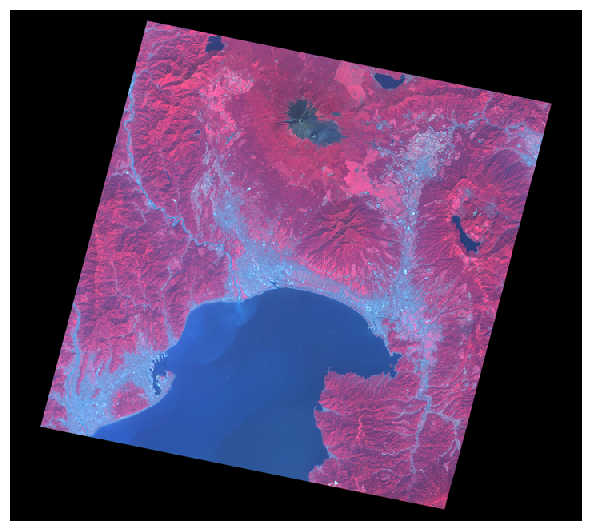

In [10]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Downsample the scene for plotting
dsfactor = 10

# Choose bands for our RGB composite
bands = [3, 2, 1]

# Normalization value for rendering
norm_value = 100

image_data = []

with rasterio.open(swir_asset.href, "r") as src:

    h = int(src.height // dsfactor)
    w = int(src.width // dsfactor)

    for i, band in enumerate(bands):
        band_array = src.read(band, out_shape=(1, h, w))
        band_array = band_array / norm_value
        image_data.append(band_array)
    src.close()

rgb = np.dstack((image_data[0], image_data[1], image_data[2]))
np.clip(rgb, 0, 1, rgb)

dpi = 100
fig = plt.figure(frameon=False, figsize=(w / dpi, h / dpi), dpi=dpi)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(rgb);